In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, SparsePCA, TruncatedSVD
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.spatial.distance import pdist,cdist, squareform
from functions import *
from sklearn.metrics import silhouette_score, adjusted_rand_score
import random
import umap
from sklearn.decomposition import KernelPCA

SEED = 5
random.seed(SEED)

def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

# loading the 50-dimensional PCA of the PBMC3k dataset - our ground dataset
X = TwoGuassians(distance=2)
#X /= np.max( cdist(X,X, metric='euclidean') )
### creating the impostor
n = int(len(X))
C = 10000
D_squared = cdist(X,X, metric='sqeuclidean')
D_squared /= np.max(D_squared)
D_squared_impostor = D_squared + C*(np.ones((n,n)) - np.eye(n)) 
D_squared_impostor /= np.max(D_squared_impostor)
H = np.eye(n) - np.ones((n,n)) / n
X_impostor = KernelPCA(n_components=n-1, kernel='precomputed', random_state=SEED).fit_transform( - H @ D_squared_impostor @ H / 2.0 )


In [188]:
def pca(X, noise_scale = 0.1, n_components=2):
    # Step 1: center data
    X_centered = X - X.mean(axis=0)

    rng = np.random.default_rng(SEED)
    # Step 2: compute SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    noise = rng.normal(scale=noise_scale, size=Vt.shape)
    Vt = Vt + noise

    # Step 3: project data onto top principal components
    if n_components is None:
        n_components = X.shape[1]
    X_reduced = X_centered @ Vt[:n_components].T

    # Step 4: return
    return X_reduced #, Vt[:n_components], S[:n_components]

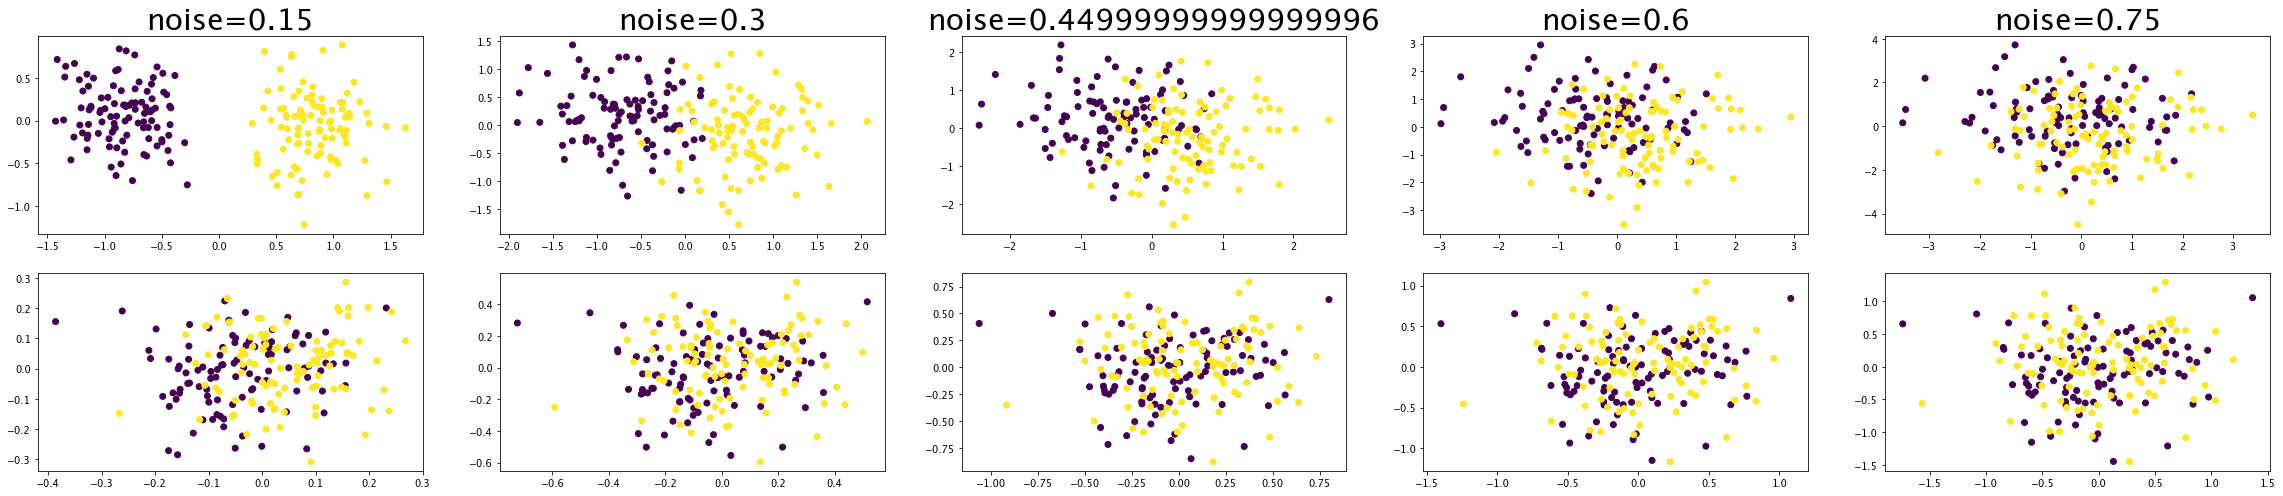

In [189]:
y=[0]*100 + [1]*100
noise_scales = [0.15*(i+1) for i in range(5)]
fig, axs = plt.subplots(2, len(noise_scales), figsize=(40,8))
for i in range(len(noise_scales)):
    n = noise_scales[i]
    X_pca = pca(X, noise_scale=n)
    X_pca_impostor = pca(X_impostor, noise_scale=n)

    axs[0, i].set_title(f'noise={n}', fontsize=30)
    axs[0, i].scatter(X_pca[:,0], X_pca[:,1], c=y)
    axs[1, i].scatter(X_pca_impostor[:,0], X_pca_impostor[:,1], c=y)


In [190]:
### run t-SNE and PCA on the impostor and the original dataset

#pca = PCA(n_components=2,random_state=SEED)
tsne = TSNE(n_components=2, random_state=SEED)

X_pca = pca(X)#pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

X_pca_impostor = pca(X_impostor)
X_tsne_impostor = tsne.fit_transform(X_impostor)

In [191]:
#PCA(n_components=10, random_state=SEED).fit(X_impostor).explained_variance_ratio_, PCA(n_components=10, random_state=SEED).fit(X).explained_variance_ratio_
np.linalg.norm(np.mean(X_impostor, axis=0)), len(np.mean(X_impostor, axis=0))

(5.847116466593605e-16, 199)

Text(0.5, 1.0, 'tsne imp')

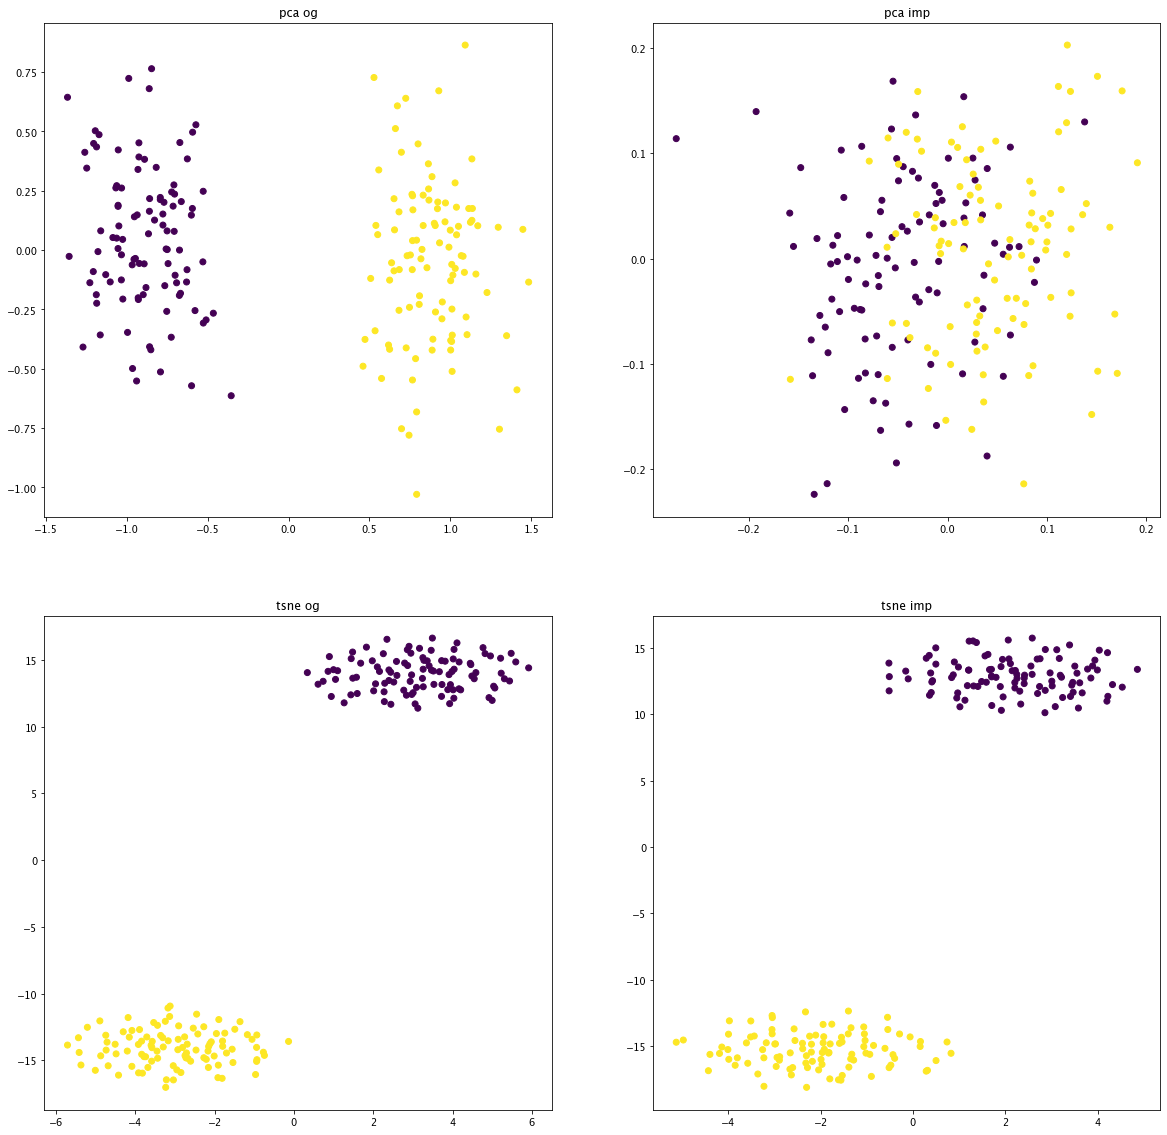

In [192]:
fig,axs = plt.subplots(2,2, figsize=(20,20))
y=[0]*100 + [1]*100
axs[0,0].scatter(X_pca[:,0],X_pca[:,1],c=y)
axs[0,0].set_title('pca og')
axs[0,1].scatter(X_pca_impostor[:,0],X_pca_impostor[:,1],c=y)
axs[0,1].set_title('pca imp')

axs[1,0].scatter(X_tsne[:,0],X_tsne[:,1],c=y)
axs[1,0].set_title('tsne og')
axs[1,1].scatter(X_tsne_impostor[:,0],X_tsne_impostor[:,1],c=y)
axs[1,1].set_title('tsne imp')